In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt 

In [2]:
# Load the MATLAB file 
EEG_data = loadmat('/home/costanza/thesis/Datasets/BCI_Competition_IV/calib/BCICIV_1_mat/BCICIV_calib_ds1d.mat', struct_as_record = True)

# List all the keys in the loaded data
keys = EEG_data.keys()

# Print the keys variables to identify the correct key for EEG data
print(keys)

dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])


In [3]:
# Extract data
markers = EEG_data['mrk']
sfreq = EEG_data['nfo']['fs'][0][0][0][0]
EEGdata   = EEG_data['cnt'].T 
nchannels, nsamples = EEGdata.shape

time_unit = 1 / sfreq
print("Time Unit:", time_unit, "seconds")

chan_names = [s[0] for s in EEG_data['nfo']['clab'][0][0][0]]

event_onsets  = EEG_data['mrk'][0][0][0] # Time points when events occurred
event_codes   = EEG_data['mrk'][0][0][1] # It contains numerical or categorical labels associated with each event.
event_onset_time = event_onsets * time_unit # Seconds

# Creates an array of zeros and then assigns the event codes to the corresponding positions based on the event onsets.
labels = np.zeros((1, nsamples), int)
labels[0, event_onsets] = event_codes

cl_lab = [s[0] for s in EEG_data['nfo']['classes'][0][0][0]]
cl1    = cl_lab[0]
cl2    = cl_lab[1]

# Electrode positions 
xpos = EEG_data['nfo']['xpos']
ypos = EEG_data['nfo']['ypos']

nclasses = len(cl_lab)
nevents = len(event_onsets)

# Print some information
print('Shape of EEG:', EEGdata.shape)
print('Sample rate:', sfreq)
print('Number of channels:', nchannels)
print('Channel names:', chan_names)
print('Number of events (MI movements):', event_onsets.shape[1])
print('Event codes:', np.unique(event_codes))
print('Class labels:', cl_lab)
print('Number of classes:', nclasses)


Time Unit: 0.01 seconds
Shape of EEG: (59, 190473)
Sample rate: 100
Number of channels: 59
Channel names: ['AF3', 'AF4', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'CFC7', 'CFC5', 'CFC3', 'CFC1', 'CFC2', 'CFC4', 'CFC6', 'CFC8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'T8', 'CCP7', 'CCP5', 'CCP3', 'CCP1', 'CCP2', 'CCP4', 'CCP6', 'CCP8', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'PO1', 'PO2', 'O1', 'O2']
Number of events (MI movements): 200
Event codes: [-1  1]
Class labels: ['left', 'right']
Number of classes: 2


In [4]:
# Segmentation class dependent

# Dictionary to store the trials in, each class gets an entry
trials = {}

# The time window (in samples) to extract for each trial, here 0.5 -- 4.5 seconds
win = np.arange(int(0.5*sfreq), int(4.5*sfreq)) # 400 samples
nsamples_win = len(win)

# Loop over the classes (left, foot)
for cl, code in zip(cl_lab, np.unique(event_codes)):

    # Extract the onsets for the class
    cl_onsets = event_onsets[event_codes == code]

    # Allocate memory for the trials
    trials[cl] = np.zeros((nchannels, nsamples_win, len(cl_onsets)))

    # Extract each trial
    for i, onset in enumerate (cl_onsets):
        trials[cl][:,:,i] = EEGdata[:,win + onset]

print('Shape of trials[cl1]:', trials[cl1].shape)
print('Shape of trials[cl2]:', trials[cl2].shape)

Shape of trials[cl1]: (59, 400, 100)
Shape of trials[cl2]: (59, 400, 100)


In [5]:
trials

{'left': array([[[   99.,   143.,    86., ...,   185.,  -102.,   -80.],
         [  119.,   135.,   106., ...,   210.,   -43.,   -49.],
         [  117.,   106.,   165., ...,   277.,   -38.,   -69.],
         ...,
         [   -2.,    39.,   104., ...,  -101.,  -221.,  -384.],
         [  -38.,    76.,   115., ...,   -90.,  -206.,  -362.],
         [  -61.,    96.,   193., ...,  -107.,  -266.,  -385.]],
 
        [[   63.,  1238.,   423., ...,   587.,   553.,   630.],
         [   87.,  1249.,   384., ...,   582.,   656.,   650.],
         [  133.,  1239.,   484., ...,   604.,   696.,   577.],
         ...,
         [ -597.,   273.,   307., ...,  -417.,  -411.,  -567.],
         [ -672.,   370.,   292., ...,  -362.,  -419.,  -543.],
         [ -729.,   375.,   357., ...,  -355.,  -553.,  -614.]],
 
        [[   82.,   205.,   194., ...,   176.,   -44.,   -51.],
         [  100.,   204.,   206., ...,   196.,     9.,   -29.],
         [  102.,   169.,   253., ...,   255.,     6.,   -35.]

In [6]:
left  = np.rollaxis(trials[cl1], 2, 0)  
right = np.rollaxis(trials[cl2], 2, 0)
data = np.concatenate([left, right])

Y = np.concatenate([-np.ones(left.shape[0]), np.ones(right.shape[1])])

print(data.shape)
print(Y.shape)

(200, 59, 400)
(159,)


In [7]:
import mne

In [8]:
n_channels = 59

# Initialize an info structure
info = mne.create_info(
    ch_names = chan_names,
    ch_types = ['eeg'] * nchannels,
    sfreq = sfreq
)

print('Event created:', info)

Event created: <Info | 7 non-empty values
 bads: []
 ch_names: AF3, AF4, F5, F3, F1, Fz, F2, F4, F6, FC5, FC3, FC1, FCz, FC2, ...
 chs: 59 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 50.0 Hz
 meas_date: unspecified
 nchan: 59
 projs: []
 sfreq: 100.0 Hz
>


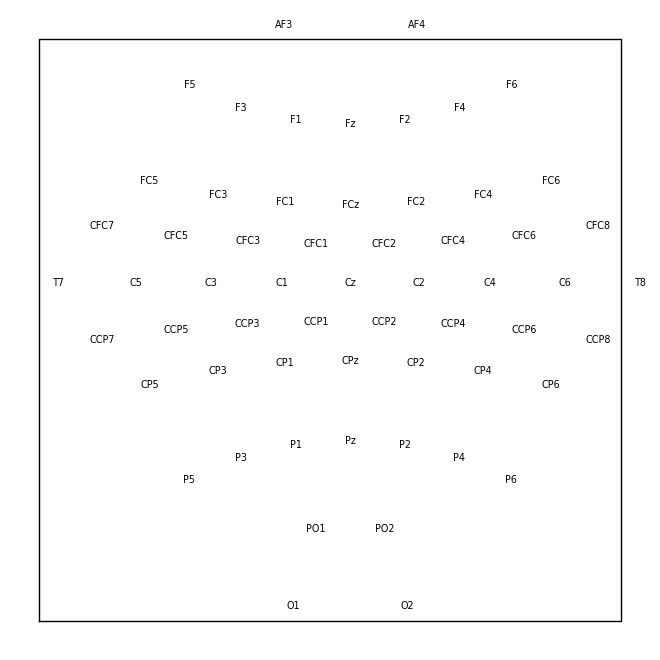

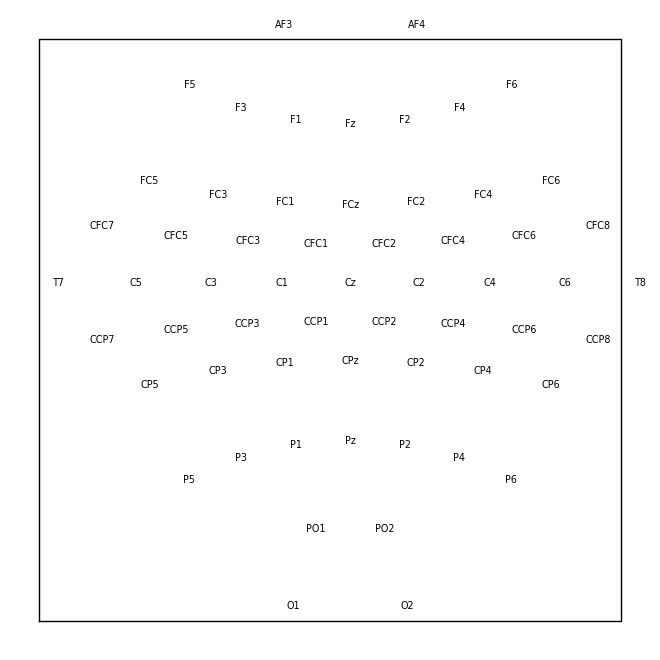

In [9]:
xpos = EEG_data['nfo']['xpos'][0][0]
ypos = EEG_data['nfo']['ypos'][0][0]
layout_pos = np.concatenate((xpos, ypos), axis = 1)

layout = mne.channels.generate_2d_layout(
    xy = layout_pos,
    ch_names = chan_names,
    name = 'EEG custom layout',
)

layout.plot()

In [17]:
from matplotlib import pyplot as plt

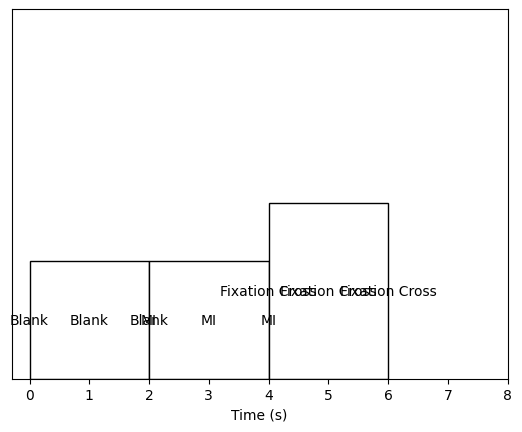

In [79]:
import matplotlib.pyplot as plt
import numpy as np

x1 = np.arange(3) # blank screen
x2 = np.arange(2,5) # MI
x3 = np.arange(4,7) # fixation cross (overlaps the MI)

n_bins = 1

plt.hist(x1, edgecolor='black', bins=n_bins, color = 'white', height = 1)
plt.hist(x2, edgecolor='black', bins=n_bins, color = 'white', height = 1)
plt.hist(x3, edgecolor='black', bins=n_bins, color = 'White', height = 1.5)

plt.xticks(np.arange(0, 9, 1))
plt.yticks(np.arange(0))

plt.xlabel('Time (s)')

# Add text inside the bins
for x_val in x1:
    plt.text(x_val, 0.5, 'Blank', ha='center', va='center')

for x_val in x2:
    plt.text(x_val, 0.5, 'MI', ha='center', va='center')

for x_val in x3:
    plt.text(x_val, 0.75, 'Fixation Cross', ha='center', va='center')


plt.show()